## Overview
The project aims to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate, we will use a dataset of comments from Wikipedia’s talk page edits, collected by Kaggle. Improvements to the current model will hopefully help online discussion become more productive and respectful.

### Metrics
There are six labels, the results are evaluated on the mean column-wise ROC AUC. In other words, the score is the average of the individual AUCs of each predicted column. So the performance metrics for the model is AUC of each label.

### Packages

In [1]:
reset -f

In [96]:
from statistics import mean
import pandas as pd
import numpy as np
import re, string
from nltk.stem.wordnet import WordNetLemmatizer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_auc_score, confusion_matrix
import statistics
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score

from wordcloud import WordCloud
import itertools

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Loading data

In [3]:
train  = pd.read_csv("data/train.csv")
test  = pd.read_csv("data/test.csv")
test_y  = pd.read_csv("data/test_labels.csv")

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
test_y.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


#### Display the comment length

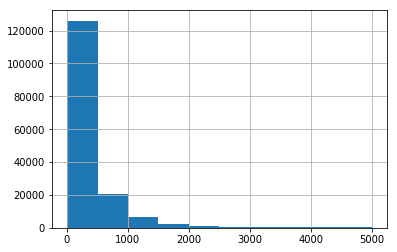

In [7]:
comment_len = train.comment_text.str.len() 
comment_len.hist()

#### Plot the labeled data frequency. there is class imbalance.

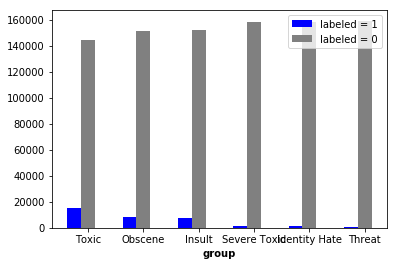

In [8]:
 barWidth = 0.25

bars1 = [sum(train['toxic']==1), sum(train['obscene']==1), sum(train['insult']==1), sum(train['severe_toxic']==1),
              sum(train['identity_hate']==1), sum(train['threat']==1)]
bars2 = [sum(train['toxic']==0), sum(train['obscene']==0), sum(train['insult']==0), sum(train['severe_toxic']==0),
              sum(train['identity_hate']==0), sum(train['threat']==0)]
 
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

plt.bar(r1, bars1, color='blue', width=barWidth, label='labeled = 1')
plt.bar(r2, bars2, color='grey', width=barWidth, label='labeled = 0')

plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Toxic', 'Obscene', 'Insult', 'Severe Toxic', 'Identity Hate', 
                                                      'Threat'])
plt.legend()
plt.show()

In [9]:
train.comment_text[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

#### Words contributing the most

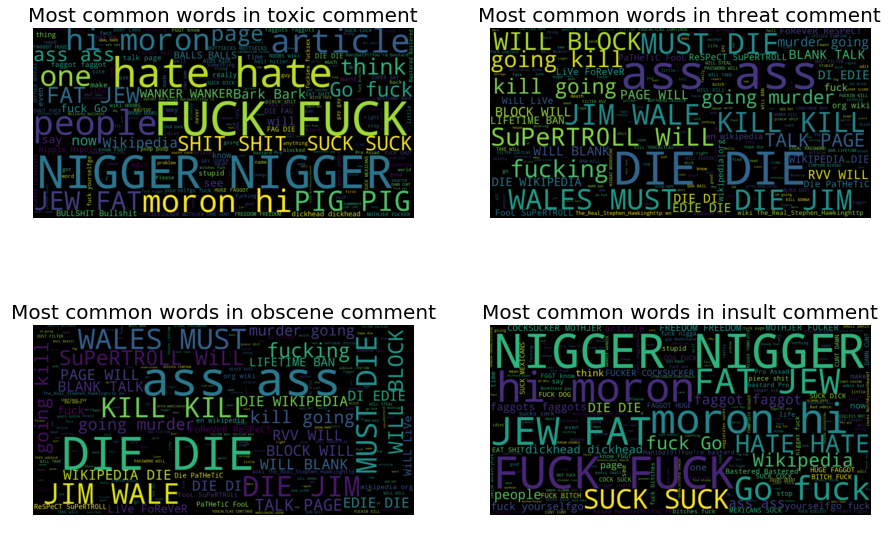

In [110]:
toxic_context = train[train.toxic == 1]   
toxic_text = toxic_context.comment_text
neg_text = pd.Series(toxic_text).str.cat(sep=' ')             
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)

%matplotlib inline
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most common words in toxic comment", size=20)
#plt.show()


threat_context = train[train.threat == 1]   
threat_text = threat_context.comment_text
neg_text = pd.Series(threat_text).str.cat(sep=' ')             
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)

#plt.figure(figsize=(15,10))
plt.subplot(222)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most common words in threat comment", size=20)
#plt.show()


obscene_context = train[train.obscene == 1]   
obscene_text = obscene_context.comment_text
neg_text = pd.Series(threat_text).str.cat(sep=' ')             
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)

#plt.figure(figsize=(15,10))
plt.subplot(223)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most common words in obscene comment", size=20)
#plt.show()


insult_context = train[train.insult == 1]   
insult_text = insult_context.comment_text
neg_text = pd.Series(insult_text).str.cat(sep=' ')             
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)

#plt.figure(figsize=(15,10))
plt.subplot(224)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most common words in insult comment", size=20)
#plt.show()
plt.show()


In [109]:
# threat_context = train[train.threat == 1]   
# threat_text = threat_context.comment_text
# neg_text = pd.Series(threat_text).str.cat(sep=' ')             
# wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_text)

# plt.figure(figsize=(15,10))
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.title("Most common words assosiated with threat comment", size=20)
# plt.show()

### Modeling

In [20]:
test_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [23]:
def tokenize(text):
    text=text.lower()
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    nopunct = regex.sub(" ", text)
    words=nopunct.split(' ')
    #remove any non ascii 
    words=[word.encode('ascii','ignore').decode('ascii') for word in words]
    lmtzr=WordNetLemmatizer()
    words=[lmtzr.lemmatize(w) for w in words]
    words=[w for w in words if len(w)>2]
    return words

In [38]:
vect1 = TfidfVectorizer(ngram_range=(1,1), analyzer= 'word' , tokenizer = tokenize , stop_words='english',
            strip_accents='unicode', use_idf=1, min_df=10)
X_train_vec1 = vect1.fit_transform(train['comment_text'])
X_test_vec1 = vect1.transform(test['comment_text'])

In [71]:
clf1 = LogisticRegression(class_weight="balanced")
clf2 = MultinomialNB()
#clf3 = svm.LinearSVC(class_weight = {1:20})
clf3 = svm.LinearSVC(class_weight = 'balanced')

In [72]:
def score(classifier, X_train, y_train, X_test, y_test):
    methods = []
    for label in test_labels:
        classifier.fit(X_train, y_train[label])
        predicted = classifier.predict(X_test)
    
        auc = roc_auc_score(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])
        precision = precision_score(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])
        recall = recall_score(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])
        f1 = f1_score(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])

        conf_mat = confusion_matrix(y_test[y_test[label]!=-1][label], predicted[y_test[label]!=-1])
        methods.append([label,auc,precision,recall,f1,conf_mat])
        
    return methods


In [118]:
methods1=pd.DataFrame(score(clf1, X_train_vec1, train, X_test_vec1, test_y))
methods1.columns = ['Label', 'AUC_ROC', 'Precision', 'Recall', 'F1', "Confussion_Matrix"]

print("********************")
print("Tfidf Vectorizer with Logistic Classifier")
methods1

********************
Tfidf Vectorizer with Logistic Classifier


,Label,AUC_ROC,Precision,Recall,F1,Confussion_Matrix
0,toxic,0.891504,0.415954,0.918719,0.572642,"[[50032, 7856], [495, 5595]]"
1,severe_toxic,0.941542,0.115977,0.923706,0.206079,"[[61027, 2584], [28, 339]]"
2,obscene,0.907962,0.423816,0.890003,0.574200,"[[55821, 4466], [406, 3285]]"
3,threat,0.911990,0.157194,0.838863,0.264772,"[[62818, 949], [34, 177]]"
4,insult,0.898899,0.360627,0.886781,0.512738,"[[55163, 5388], [388, 3039]]"
5,identity_hate,0.906276,0.188469,0.853933,0.308786,"[[60648, 2618], [104, 608]]"


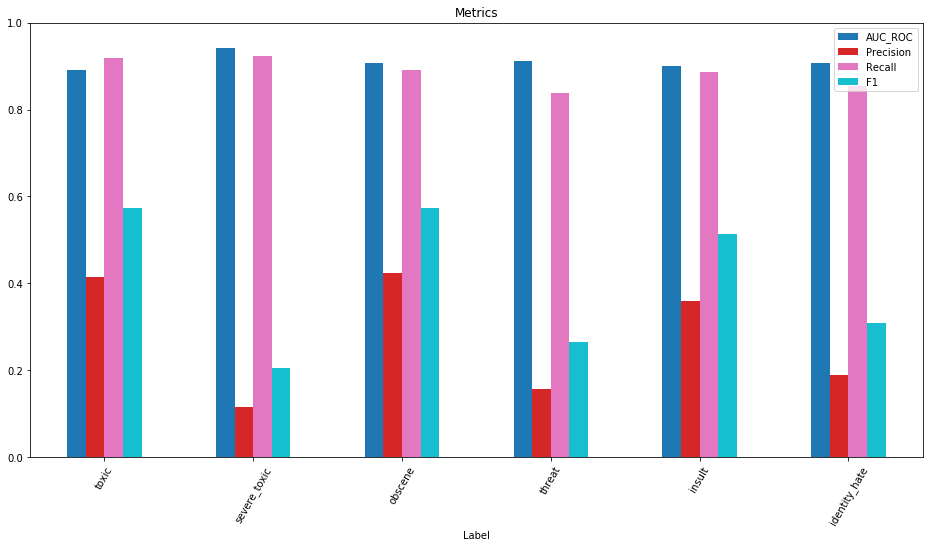

In [74]:
methods1.set_index(["Label"],inplace=True)
%matplotlib inline
methods1.plot(figsize=(16, 8),kind='bar',title='Metrics', rot=60, ylim=(0.0,1),
             colormap='tab10')

In [76]:
methods2=pd.DataFrame(score(clf2, X_train_vec1, train, X_test_vec1, test_y))
methods2.columns = ['Label', 'AUC_ROC', 'Precision', 'Recall', 'F1', "Confussion_Matrix"]

print("********************")
print("Tfidf Vectorizer with Multinomial Naïve Bayes Classifier")
methods2

********************
Tfidf Vectorizer with Multinomial Naïve Bayes Classifier


,Label,AUC_ROC,Precision,Recall,F1,Confussion_Matrix
0,toxic,0.755183,0.713814,0.532841,0.610192,"[[56587, 1301], [2845, 3245]]"
1,severe_toxic,0.531241,0.657143,0.062670,0.114428,"[[63599, 12], [344, 23]]"
2,obscene,0.724747,0.824424,0.455432,0.586736,"[[59929, 358], [2010, 1681]]"
3,threat,0.500000,0.000000,0.000000,0.000000,"[[63767, 0], [211, 0]]"
4,insult,0.680955,0.766707,0.368252,0.497536,"[[60167, 384], [2165, 1262]]"
5,identity_hate,0.501397,0.666667,0.002809,0.005594,"[[63265, 1], [710, 2]]"


In [78]:
methods3=pd.DataFrame(score(clf3, X_train_vec1, train, X_test_vec1, test_y))
methods3.columns = ['Label', 'AUC_ROC', 'Precision', 'Recall', 'F1', "Confussion_Matrix"]

print("********************")
print("Tfidf Vectorizer with LinearSVC")
methods3

********************
Tfidf Vectorizer with LinearSVC


,Label,AUC_ROC,Precision,Recall,F1,Confussion_Matrix
0,toxic,0.873800,0.389691,0.895074,0.542982,"[[49351, 8537], [639, 5451]]"
1,severe_toxic,0.865877,0.159104,0.754768,0.262808,"[[62147, 1464], [90, 277]]"
2,obscene,0.880158,0.431093,0.827147,0.566787,"[[56258, 4029], [638, 3053]]"
3,threat,0.777527,0.306494,0.559242,0.395973,"[[63500, 267], [93, 118]]"
4,insult,0.855580,0.369235,0.787278,0.502702,"[[55942, 4609], [729, 2698]]"
5,identity_hate,0.805646,0.299598,0.627809,0.405626,"[[62221, 1045], [265, 447]]"


### Model comparison

In [81]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Toxic classification',
                          cmap=plt.cm.YlGnBu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

***************Toxic labelling***************
*********************************************


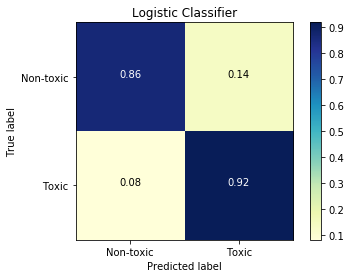

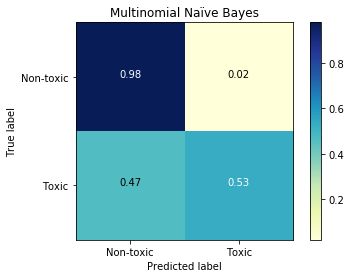

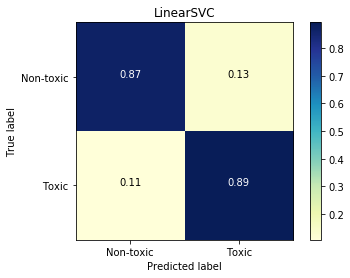

In [82]:
methods = [ (methods1,'Logistic Classifier'), (methods2,'Multinomial Naïve Bayes'), (methods3,'LinearSVC')]
print("***************Toxic labelling***************")
print("*********************************************")
for i in range(0,3):
    cm = methods[i][0]["Confussion_Matrix"][0]
    plot_confusion_matrix(cm,["Non-toxic","Toxic"],True, methods[i][1])

Different models are doing well in minizing different types of errors. If we look at Multinomial Naive Bayes it is doing extremely well in terms of Precision. The number of False Positives have been minimized to a great extent. If we look at LinearSVC and Logisitic Classifier , they are doing extremely well in terms of Recall or True Positive Rate. It has minimizing the False Negatives to a great extent.


In [85]:
clf4=RandomForestClassifier()

In [87]:
# # Creating pipeline for combining the preprocessing and classification steps
# pipe_log=Pipeline(steps=[('vect',vect1),('log',clf1)])
# pipe_mnb=Pipeline(steps=[('vect',vect1),('mnb',clf2)])
# pipe_svc=Pipeline(steps=[('vect',vect1),('svc',clf3)])
# pipe_rf=Pipeline(steps=[('vect',vect1),('rf',clf4)])

# #Now creating a list of pipelines for each model shown above
# pipelines = [pipe_log, pipe_mnb, pipe_svc, pipe_rf]



In [119]:
# score_df = []
# for pipe in pipelines:
#     f1_values = [] 
#     auc_values = []
#     f2_values = []
#     recall_values = []
#     for label in test_labels:
#         pipe.fit(train['comment_text'], train[label])
#         predicted = pipe.predict(test['comment_text'])
    
#         auc_values.append(roc_auc_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1],average='weighted'))
#         f1_values.append(f1_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1],average='weighted'))
#         f2_values.append(fbeta_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1],beta=2,average='weighted'))
#         recall_values.append(recall_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1],average='weighted'))
#         name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
    
#     val = [name, mean(f1_values), mean(auc_values), mean(f2_values), mean(recall_values)]
#     score_df.append(val)  

# scores = pd.DataFrame(score_df,)
# scores.columns = ['Model','F1','AUC','F2','Recall']
# scores

In [114]:
# Creating pipeline for each model 
pipe_lr = Pipeline([
    ('lr', clf1)
])

pipe_linear_svm = Pipeline([
    ('svc', clf3)
])
  
pipe_rf = Pipeline([
    ('rf',clf4 )
])

pipe_mnb = Pipeline([
    ('mnb', clf2 )
])

pipelines = [pipe_lr, pipe_linear_svm, pipe_rf, pipe_mnb]

In [116]:
# Calculating combined metrics across labels

score_df = []
for pipe in pipelines:
    f1_values = [] 
    auc_values = []
    f2_values = []
    recall_values = []
    for label in test_labels:
        pipe.fit(X_train_vec1, train[label])
        predicted = pipe.predict(X_test_vec1)
    
        auc_values.append(roc_auc_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1],average='weighted'))
        f1_values.append(f1_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1],average='weighted'))
        f2_values.append(fbeta_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1],beta=2,average='weighted'))
        recall_values.append(recall_score(test_y[test_y[label]!=-1][label], predicted[test_y[label]!=-1],average='weighted'))
        name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
    
    val = [name, mean(f1_values), mean(auc_values), mean(f2_values), mean(recall_values)]
    score_df.append(val)  

In [117]:
scores = pd.DataFrame(score_df,)
scores.columns = ['Model','F1','AUC','F2','Recall']
scores

,Model,F1,AUC,F2,Recall
0,LogisticRegression,0.947921,0.909696,0.937322,0.934050
1,LinearSVC,0.951391,0.865514,0.943078,0.940315
2,RandomForestClassifier,0.968597,0.679917,0.968652,0.968849
3,MultinomialNB,0.968814,0.615587,0.971138,0.973061
